#### Let's Begin to code.

# Import Modules

In [2]:
# Import necessary libraries
import os   
import pickle 
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm 
import tensorflow 
from tensorflow import keras
from keras.applications.vgg16 import VGG16 , preprocess_input 
from keras.preprocessing.image import load_img , img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [3]:
# Define the base and working directories
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [4]:
# Load vgg16 Model
model = VGG16()

# Restructure the VGG16 model by excluding the last layer (output layer)
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Summarize the modified VGG16 model to understand its architecture
print(model.summary())

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [5]:
# Initialize an empty dictionary to store image features
features = {}

# Define the directory where images are stored
directory = os.path.join(BASE_DIR, 'Images')

# Iterate over each image in the directory and extract features
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file and resize it to the required input size for VGG16
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    
    # Convert the image pixels to a numpy array
    image = img_to_array(image)
    
    # Reshape the data for the VGG16 model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # Preprocess the image for VGG16
    image = preprocess_input(image)
    
    # Extract features using the pre-trained VGG16 model
    feature = model.predict(image, verbose=0)
    
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    
    # Store the extracted feature in the dictionary with the image ID as the key
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    
    # check if the line is empty or contains fewer than 2 elements
    if len(line) < 2:
        continue
    
    # extract image ID and captions from tokens
    image_id, caption = tokens[0], tokens[1:]
    
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    
    # convert caption list to string
    caption = " ".join(caption)
    
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    
    # store the caption
    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

# Preprocess Text Data

In [12]:
def clean(mapping):
    # iterate over each key-value pair in the mapping dictionary
    for key, captions in mapping.items():
        # iterate over each caption for the current key
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            
            # delete digits, special chars, etc.
            caption = caption.replace('[^A-Za-z]', '')
            
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            
            # update the caption in the list
            captions[i] = caption


In [14]:
# before preprocess of text
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [15]:
# preprocess the text
clean(mapping)

In [16]:
# after preprocess of text
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# Initialize an empty list to store all captions
all_captions = []

# Iterate over each key in the mapping dictionary
for key in mapping:
    # Iterate over each caption for the current key
    for caption in mapping[key]:
        # Append the current caption to the list
        all_captions.append(caption)


In [18]:
len(all_captions)

40455

In [19]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
# Create an instance of the Tokenizer class
tokenizer = Tokenizer()

# Fit the tokenizer on the list of all captions to build the vocabulary
tokenizer.fit_on_texts(all_captions)

# Get the total vocabulary size, considering one additional index for out-of-vocabulary words
vocab_size = len(tokenizer.word_index) + 1


In [21]:
vocab_size

8485

In [22]:

# Save the Tokenizer to a pickle file

     
tokenizer_path = os.path.join(WORKING_DIR, 'tokenizer.pkl')  # Replace with the desired path
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

# To load the Tokenizer from the pickle file
with open(tokenizer_path, 'rb') as f:
    loaded_tokenizer = pickle.load(f)

No. of unique words

In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [24]:
# Get a list of image IDs from the keys of the 'mapping' dictionary
image_ids = list(mapping.keys())

# Determine the split point for creating training and test sets
split = int(len(image_ids) * 0.90)

# Create the training set by taking the first 90% of the image IDs
train = image_ids[:split]

# Create the test set by taking the remaining 10% of the image IDs
test = image_ids[split:]


In [25]:
# Create a data generator function to yield batches of data
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize empty lists to store data
    X1, X2, y = list(), list(), list()
    
    # Counter for the number of samples processed
    n = 0
    
    # Infinite loop to keep yielding batches
    while 1:
        for key in data_keys:
            # Increment the counter
            n += 1
            
            # Get captions for the current image
            captions = mapping[key]
            
            # Process each caption
            for caption in captions:
                # Encode the text sequence using the tokenizer
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                # Split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output sequences
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    # Pad the input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    # One-hot encode the output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Store the sequences in the respective lists
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            
            # Check if the batch size is reached
            if n == batch_size:
                # Convert lists to NumPy arrays
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
                # Yield the batch
                yield [X1, X2], y
                
                # Reset lists and counter for the next batch
                X1, X2, y = list(), list(), list()
                n = 0


# Model Creation

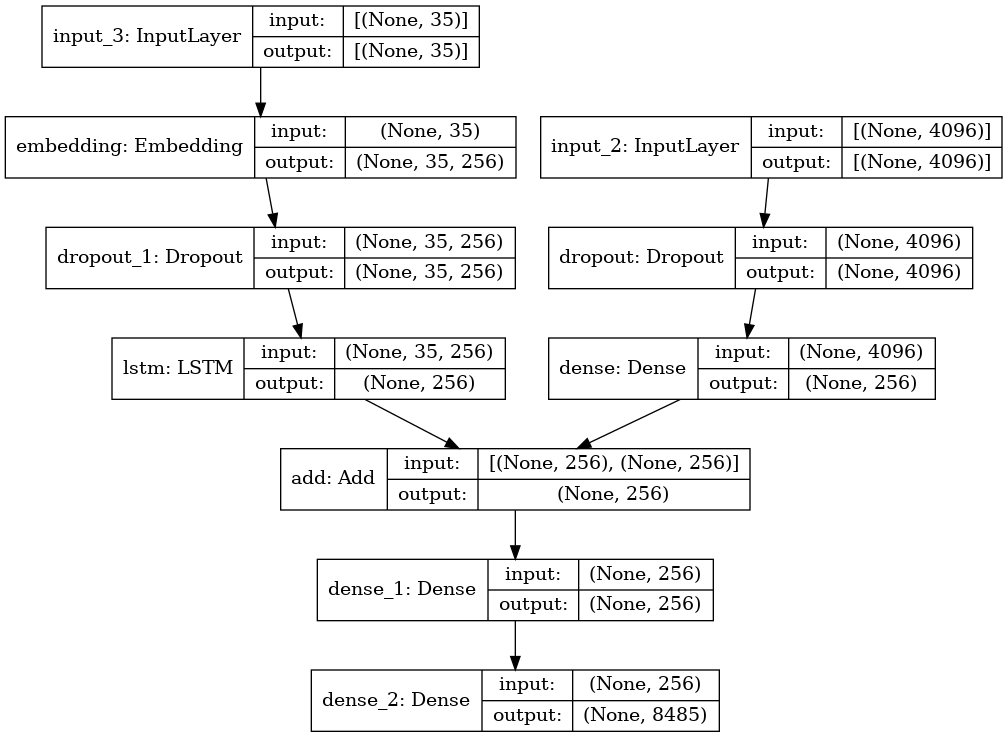

In [26]:
# Encoder Model
# Image Feature Layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence Feature Layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model
# Combine image and sequence features
decoder1 = add([fe2, se3])

# Further processing in the decoder
decoder2 = Dense(256, activation='relu')(decoder1)

# Output layer for generating the next word
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create the overall model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model architecture
plot_model(model, show_shapes=True)


# Train Model
Now let us train the model

In [27]:
# Train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # Create data generator for training
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # Fit the model for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 [==============================] - 48s 213ms/step - loss: 1.9767


In [28]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [32]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text


In [33]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.533212
BLEU-2: 0.305637


## Visualize the Results

In [38]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]

    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # display the image
    plt.imshow(image)
    plt.show()

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs play with each other on the grass endseq


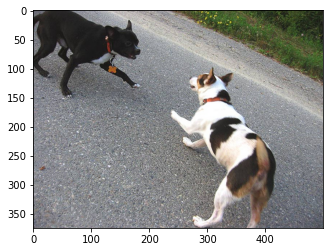

In [39]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq boy smiles in front of stony wall in city endseq
startseq little boy is standing on the street while man in overalls is working on stone wall endseq
startseq young boy runs aross the street endseq
startseq young child is walking on stone paved street with metal pole and man behind him endseq
startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq
--------------------Predicted--------------------
startseq two children are walking aross the street endseq


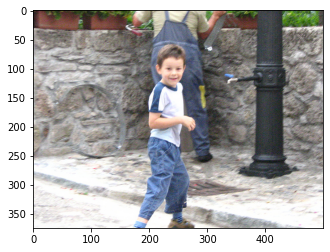

In [40]:
generate_caption("1015118661_980735411b.jpg")

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq three dogs are running through grassy field endseq


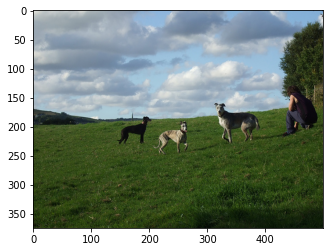

In [41]:
generate_caption("1032122270_ea6f0beedb.jpg")